In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt

In [2]:
# load the Fashion MNIST dataset and it's OK to use just the training data
(train_images, train_labels), (_, _) = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images.shape

(60000, 28, 28)

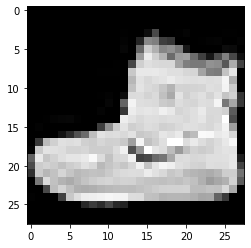

In [4]:
plt.figure()
plt.imshow(train_images[0], cmap='gray')
plt.show()

In [5]:
# Reshape data and also convert the data type to 'float32'
print(train_images.shape)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
print(train_images.shape)

# Normalize the images to [-1, 1] which is the range of the tanh activation
train_images = (train_images - 127.5) / 127.5  

(60000, 28, 28)
(60000, 28, 28, 1)


In [6]:
# latent dimension of the random noise
LATENT_DIM = 100 
# weight initializer for G per DCGAN paper
WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02) 
# number of channels, 1 for gray scale and 3 for color images
CHANNELS = 1

In [7]:
def build_generator():
    model = Sequential(name="generator")

    # prepare for reshape: FC => BN => RN layers, note: input shape defined in the 1st Dense layer  
    model.add(layers.Dense(7 * 7 * 256, input_dim=LATENT_DIM))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # 1D => 3D: reshape the output of the previous layer 
    model.add(layers.Reshape((7, 7, 256)))

    # upsample to 14x14: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # upsample to 28x28: apply a transposed CONV => BN => RELU
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2),padding="same", kernel_initializer=WEIGHT_INIT))
    model.add(layers.BatchNormalization())
    model.add((layers.ReLU()))

    # final layer: Conv2D with tanh activation
    model.add(layers.Conv2D(CHANNELS, (5, 5), padding="same", activation="tanh"))

    return model

In [8]:
# build the generator model
generator = build_generator() 

In [9]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      819328    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 128)      51

In [10]:
def build_discriminator(width, height, depth, alpha=0.2):
    model = Sequential(name="discriminator")
    input_shape = (height, width, depth)

    # first set of CONV => BN => leaky ReLU layers
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", 
              input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # second set of CONV => BN => leacy ReLU layers
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=alpha))

    # flatten and apply dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.3))

    # sigmoid in the last layer outputs a single value for binary classification
    model.add(layers.Dense(1, activation="sigmoid"))

    return model

In [11]:
# build the discriminator model
discriminator = build_discriminator(28, 28, 1) 

In [12]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 batch_normalization_3 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 batch_normalization_4 (Batc  (None, 7, 7, 128)        512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)       

In [13]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Step 1. Train the discriminator with both real images (label as 1) and fake images (classified as label as 0) 
        with tf.GradientTape() as tape:
            # Compute discriminator loss on real images
            pred_real = self.discriminator(real_images, training=True)
            d_loss_real = self.loss_fn(tf.ones((batch_size, 1)), pred_real)

            # Compute discriminator loss on fake images
            fake_images = self.generator(noise)
            pred_fake = self.discriminator(fake_images, training=True)
            d_loss_fake = self.loss_fn(tf.zeros((batch_size, 1)), pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake)/2
        # Compute discriminator gradients
        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # Update discriminator weights
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_variables))

        # Step 2. Train the generator (do not update weights of the discriminator)
        # G wants D to think the fake images are real (label as 1)
        misleading_labels = tf.ones((batch_size, 1)) 

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred_fake = self.discriminator(fake_images, training=True)
            g_loss = self.loss_fn(misleading_labels, pred_fake)
        # Compute generator gradients
        grads = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update generator weights
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

In [14]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

        # Create random noise seed for visualization during training
        self.seed = tf.random.normal([16, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        generated_images = self.model.generator(self.seed)
        generated_images = (generated_images * 127.5) + 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(4, 4))
        for i in range(self.num_img):
            plt.subplot(4, 4, i+1)
            img = keras.utils.array_to_img(generated_images[i]) 
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        plt.savefig('epoch_{:03d}.png'.format(epoch)) 
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [15]:
dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=LATENT_DIM)

In [16]:
LR = 0.0002 # learning rate

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=LR, beta_1 = 0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

Epoch 1/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.2257 - g_loss: 1.1214

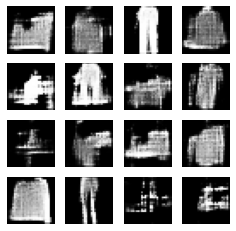

1875/1875 [==============================] - 49s 21ms/step - d_loss: 0.2259 - g_loss: 1.1217
Epoch 2/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6233 - g_loss: 1.0721

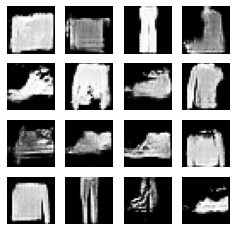

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6233 - g_loss: 1.0722
Epoch 3/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6516 - g_loss: 0.9488

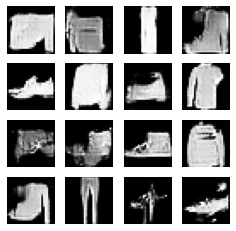

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6516 - g_loss: 0.9488
Epoch 4/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6601 - g_loss: 0.8932

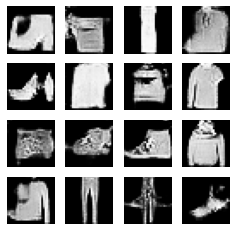

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6602 - g_loss: 0.8932
Epoch 5/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6658 - g_loss: 0.8729

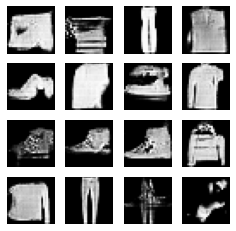

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6658 - g_loss: 0.8729
Epoch 6/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6674 - g_loss: 0.8550

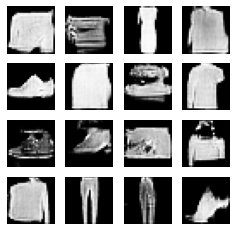

1875/1875 [==============================] - 40s 21ms/step - d_loss: 0.6674 - g_loss: 0.8549
Epoch 7/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6672 - g_loss: 0.8427

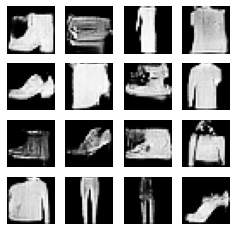

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6672 - g_loss: 0.8427
Epoch 8/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6704 - g_loss: 0.8350

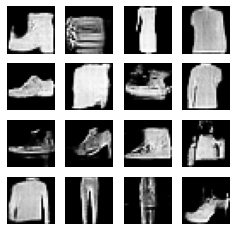

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6704 - g_loss: 0.8350
Epoch 9/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6686 - g_loss: 0.8287

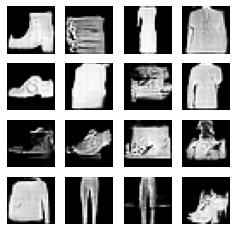

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6686 - g_loss: 0.8288
Epoch 10/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6701 - g_loss: 0.8269

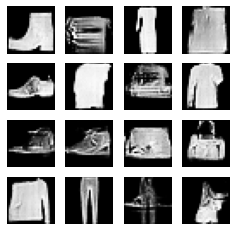

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6701 - g_loss: 0.8269
Epoch 11/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6708 - g_loss: 0.8220

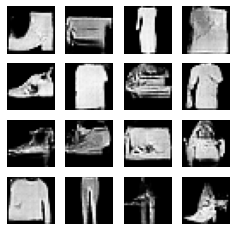

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6708 - g_loss: 0.8220
Epoch 12/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6706 - g_loss: 0.8219

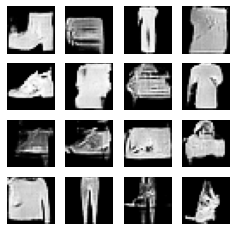

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6706 - g_loss: 0.8218
Epoch 13/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6705 - g_loss: 0.8149

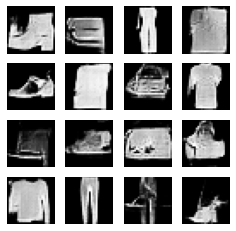

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6704 - g_loss: 0.8149
Epoch 14/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6702 - g_loss: 0.8121

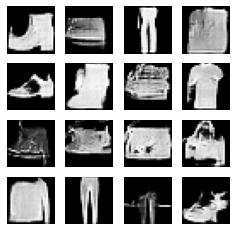

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6702 - g_loss: 0.8120
Epoch 15/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6717 - g_loss: 0.8100

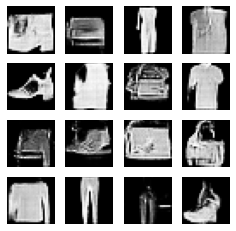

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6717 - g_loss: 0.8101
Epoch 16/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6721 - g_loss: 0.8115

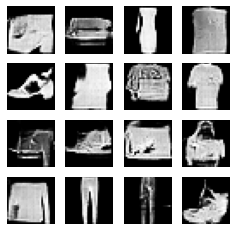

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6721 - g_loss: 0.8115
Epoch 17/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6693 - g_loss: 0.8101

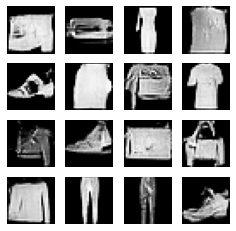

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6693 - g_loss: 0.8101
Epoch 18/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6699 - g_loss: 0.8072

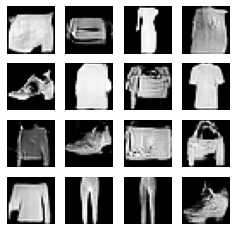

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6700 - g_loss: 0.8072
Epoch 19/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6700 - g_loss: 0.8103

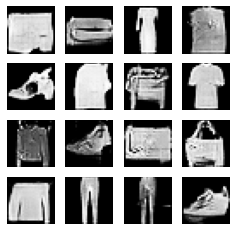

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6701 - g_loss: 0.8103
Epoch 20/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.8093

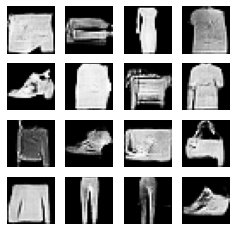

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6696 - g_loss: 0.8092
Epoch 21/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6701 - g_loss: 0.8078

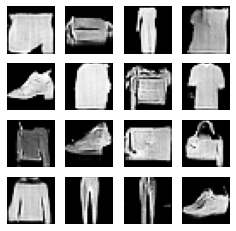

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6701 - g_loss: 0.8077
Epoch 22/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.8065

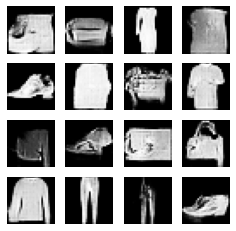

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6696 - g_loss: 0.8065
Epoch 23/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6697 - g_loss: 0.8058

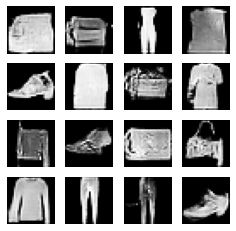

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6696 - g_loss: 0.8058
Epoch 24/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6703 - g_loss: 0.8067

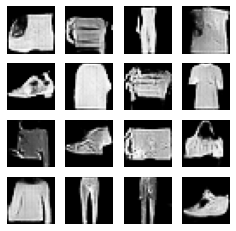

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6703 - g_loss: 0.8068
Epoch 25/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6702 - g_loss: 0.8069

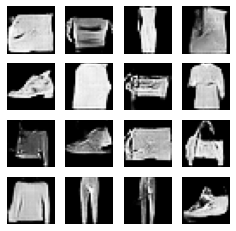

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6702 - g_loss: 0.8070
Epoch 26/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8047

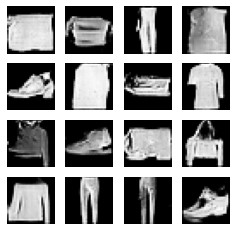

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6696 - g_loss: 0.8046
Epoch 27/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6684 - g_loss: 0.8059

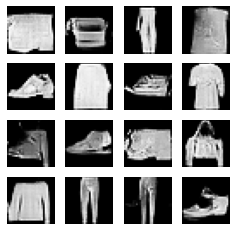

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6684 - g_loss: 0.8059
Epoch 28/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6694 - g_loss: 0.8070

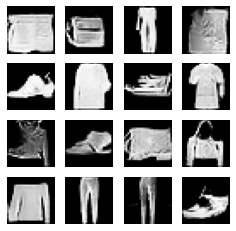

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6694 - g_loss: 0.8070
Epoch 29/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6695 - g_loss: 0.8071

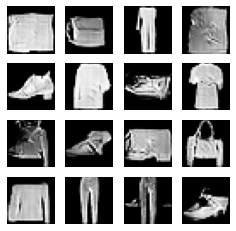

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6695 - g_loss: 0.8070
Epoch 30/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6696 - g_loss: 0.8034

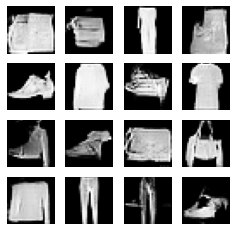

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6696 - g_loss: 0.8034
Epoch 31/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6699 - g_loss: 0.8051

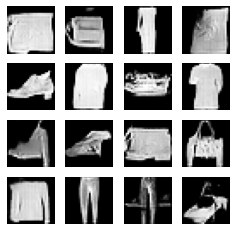

1875/1875 [==============================] - 38s 20ms/step - d_loss: 0.6699 - g_loss: 0.8051
Epoch 32/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6701 - g_loss: 0.8060

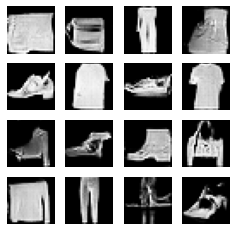

1875/1875 [==============================] - 38s 21ms/step - d_loss: 0.6701 - g_loss: 0.8060
Epoch 33/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.8045

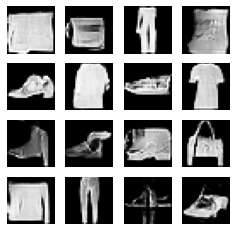

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6690 - g_loss: 0.8046
Epoch 34/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6708 - g_loss: 0.8047

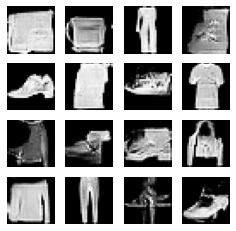

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6708 - g_loss: 0.8047
Epoch 35/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6682 - g_loss: 0.8029

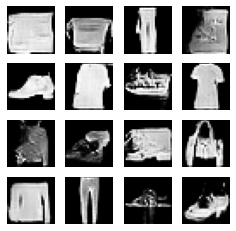

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6682 - g_loss: 0.8029
Epoch 36/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6683 - g_loss: 0.8078

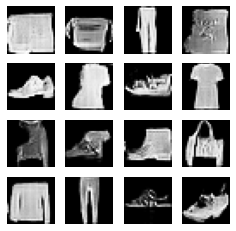

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6683 - g_loss: 0.8078
Epoch 37/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6687 - g_loss: 0.8059

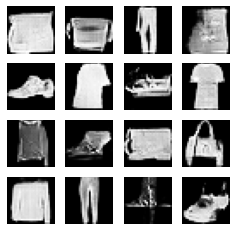

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6687 - g_loss: 0.8059
Epoch 38/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6691 - g_loss: 0.8045

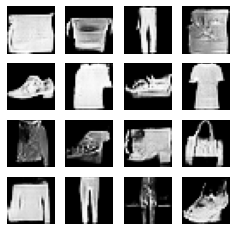

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6691 - g_loss: 0.8045
Epoch 39/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6664 - g_loss: 0.8017

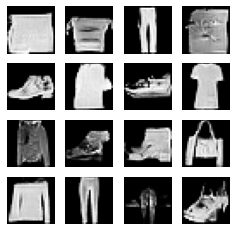

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6664 - g_loss: 0.8017
Epoch 40/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6676 - g_loss: 0.8054

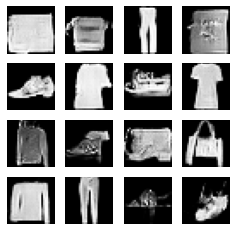

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6676 - g_loss: 0.8054
Epoch 41/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6679 - g_loss: 0.8010

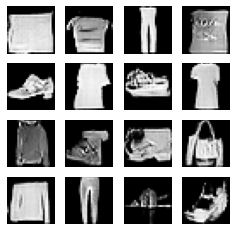

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6679 - g_loss: 0.8010
Epoch 42/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6675 - g_loss: 0.8048

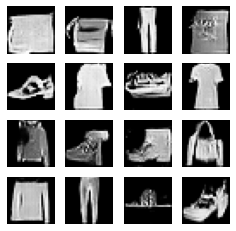

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6675 - g_loss: 0.8048
Epoch 43/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6688 - g_loss: 0.8033

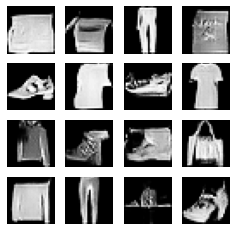

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6688 - g_loss: 0.8034
Epoch 44/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6675 - g_loss: 0.8024

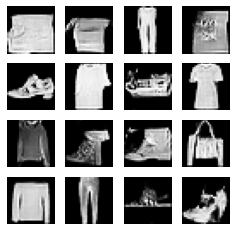

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6675 - g_loss: 0.8024
Epoch 45/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6661 - g_loss: 0.8050

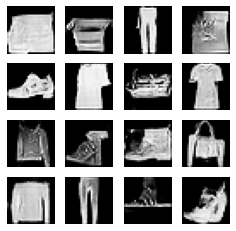

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6661 - g_loss: 0.8050
Epoch 46/50
1873/1875 [============================>.] - ETA: 0s - d_loss: 0.6661 - g_loss: 0.8049

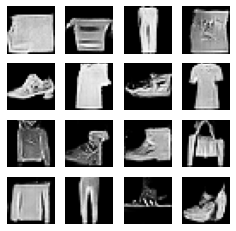

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6661 - g_loss: 0.8049
Epoch 47/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6670 - g_loss: 0.8115

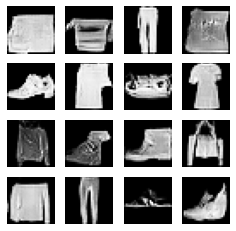

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6670 - g_loss: 0.8115
Epoch 48/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6665 - g_loss: 0.8089

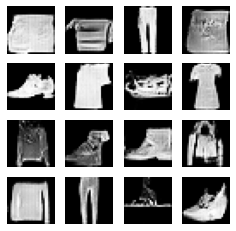

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6666 - g_loss: 0.8089
Epoch 49/50
1875/1875 [==============================] - ETA: 0s - d_loss: 0.6654 - g_loss: 0.8127

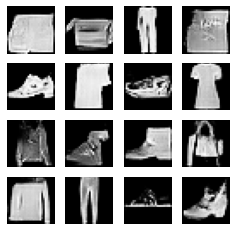

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6654 - g_loss: 0.8127
Epoch 50/50
1874/1875 [============================>.] - ETA: 0s - d_loss: 0.6657 - g_loss: 0.8113

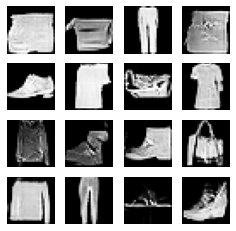

1875/1875 [==============================] - 39s 21ms/step - d_loss: 0.6657 - g_loss: 0.8113


In [17]:
NUM_EPOCHS = 50 
dcgan.fit(train_images, epochs=NUM_EPOCHS, callbacks=[GANMonitor(num_img=16, latent_dim=LATENT_DIM)])